In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from fuzzywuzzy import process
import requests

In [3]:
# Retrieve the NYtimes API key
nyt_api = os.getenv("NYT_SECRET_KEY")

In [57]:
company_request = 'tesla'

In [58]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [59]:
company = getCompany(company_request)

In [60]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

TSLA
TESLA INC


In [61]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 completed


In [62]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [117]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,NaN,23.889999,23.889999,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,-0.002511,23.859792,23.859896,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,-0.078473,23.217729,23.222202,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,-0.125683,22.192315,22.206173,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,-0.160938,20.941893,20.969978,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [90]:
analyzer = SentimentIntensityAnalyzer()

In [91]:
import requests
import json
import time

In [92]:
response=[]
for i in range(100):
    try:
        request_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?q=" + company_name + "&page=" + str(i) + "&api-key=" + nyt_api
        
        response_data = requests.get(request_url).json()
        news_data = response_data['response']['docs']
        time.sleep(6)
        for x in news_data:
            response.append(x)
    except:
        pass

In [93]:
len(response)

1000

In [94]:
response2 = pd.DataFrame(response)

In [95]:
#response2

In [96]:
# Define a function to get the sentiment scores
def get_sentiment_scores(abstract, lead_paragraph, date, url):
    sentiment_scores = {}

    # Sentiment scoring with VADER
    text_sentiment = analyzer.polarity_scores(lead_paragraph)
    sentiment_scores["pub_date"] = date
    sentiment_scores["abstract"] = abstract
    sentiment_scores["lead_paragraph"] = lead_paragraph
#    sentiment_scores["source"] = source
    sentiment_scores["web_url"] = url
    sentiment_scores["compound"] = text_sentiment["compound"]
    sentiment_scores["pos"] = text_sentiment["pos"]
    sentiment_scores["neu"] = text_sentiment["neu"]
    sentiment_scores["neg"] = text_sentiment["neg"]
    if text_sentiment["compound"] >= 0.05:  # Positive
        sentiment_scores["normalized"] = 1
    elif text_sentiment["compound"] <= -0.05:  # Negative
        sentiment_scores["normalized"] = -1
    else:
        sentiment_scores["normalized"] = 0  # Neutral

    return sentiment_scores

In [97]:
# Empty list to store the DataFrame structure
sentiments_data = []

# Loop through all the news articles
for article in response:
    try:
        # Get sentiment scoring using the get_sentiment_score() function
        sentiments_data.append(
            get_sentiment_scores(
                article["abstract"],
                article["lead_paragraph"],
                article["pub_date"][:10],
#                article["source"],
                article["web_url"],
            )
        )

    except AttributeError:
        pass

# Create a DataFrame with the news articles' data and their sentiment scoring results
news_df = pd.DataFrame(sentiments_data)

# Sort the DataFrame rows by date
news_df = news_df.sort_values(by="pub_date")

# Define the date column as the DataFrame's index
news_df.set_index("pub_date", inplace=True)

In [118]:
news_sent = news_df[['compound','normalized']]
signal_data =  pd.concat([data, news_sent], axis=1)
signal_data.drop(signal_data.index[0], inplace=True)
signal_data.fillna(0, inplace=True)
signal_data= signal_data[signal_data.Open != 0]

In [119]:
signal_data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,compound,normalized
2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300.0,0.000000,23.889999,23.889999,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100.0,-0.002511,23.859792,23.859896,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800.0,-0.078473,23.217729,23.222202,0.0,...,-1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800.0,-0.125683,22.192315,22.206173,0.0,...,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900.0,-0.160938,20.941893,20.969978,0.0,...,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06,335.000000,338.859985,334.769989,335.890015,335.890015,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.312001,9.684098,350.996099,331.627903,0.0,0.0,0.0,0.0,0.0
2019-12-06,335.000000,338.859985,334.769989,335.890015,335.890015,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.312001,9.684098,350.996099,331.627903,0.0,0.0,0.0,0.0,0.0
2019-12-06,335.000000,338.859985,334.769989,335.890015,335.890015,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.312001,9.684098,350.996099,331.627903,0.0,0.0,0.0,0.0,0.0
2019-12-09,336.589996,344.450012,335.079987,339.529999,339.529999,9023100.0,0.010837,277.820465,277.335008,1.0,...,1.0,341.431500,9.644573,351.076073,331.786927,0.0,0.0,0.0,0.0,0.0


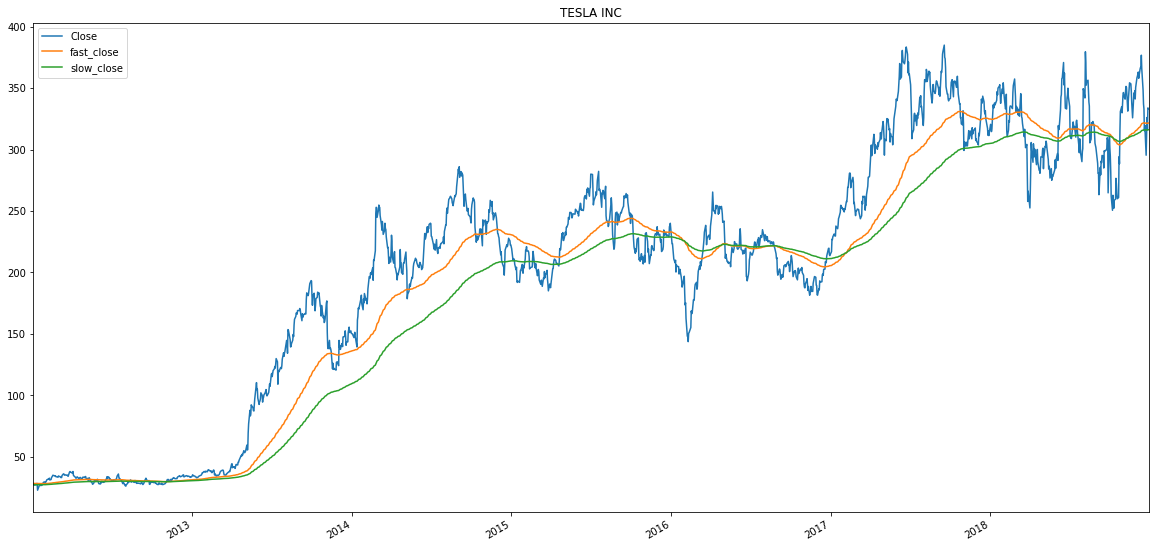

In [120]:
signal_data.loc['2012-01-01':'2019-01-01'][['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

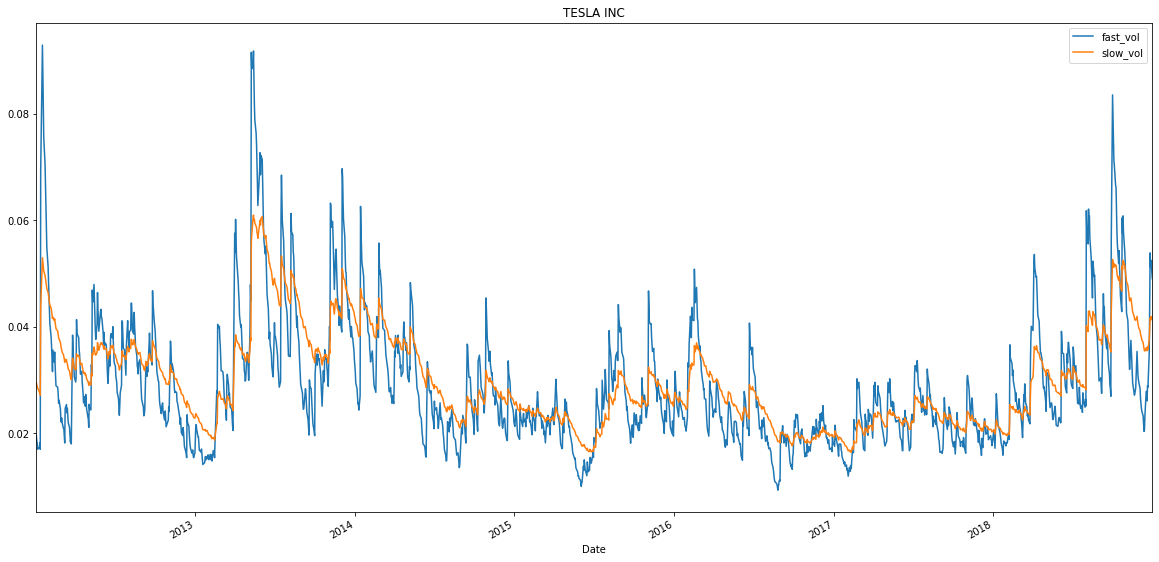

In [124]:
data.loc['2012-01-01':'2019-01-01'][['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

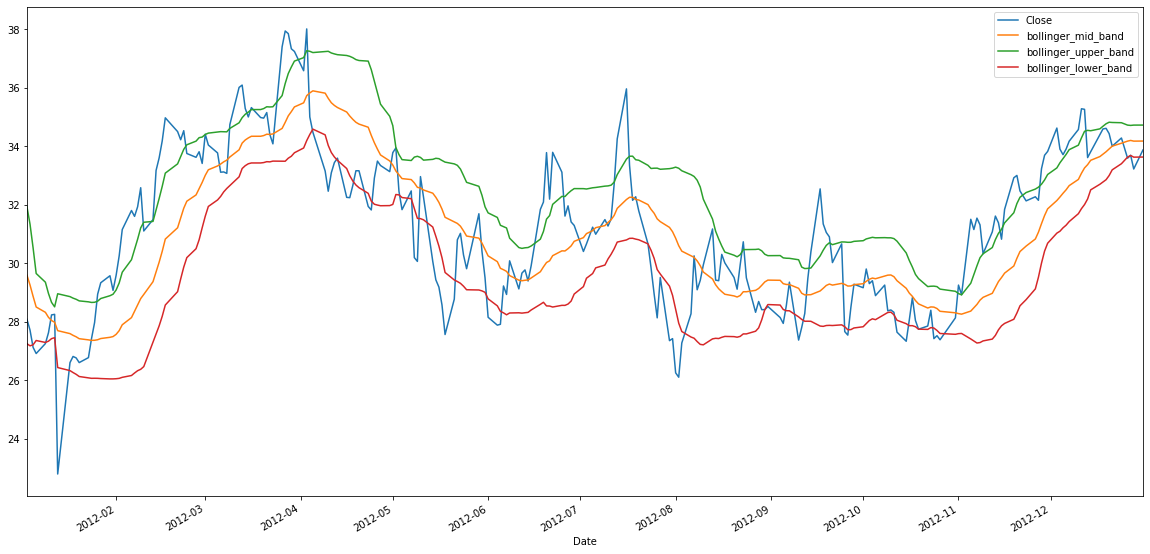

In [126]:
# Plot the Bollinger Bands for BTC/USD closing prices
data.loc['2012-01-01':'2013-01-01'][['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))